## Exploring Key Factors Influencing GitHub Repository Popularity

What factors significantly influence the popularity of a repository (i.e., the number of Stars)? Can we predict the number of Stars a repository receives using these factors?

In [1]:
#Load library
library(readr)
library(tidyverse)
library(rsample)
library(leaps)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#Load dataset
repositories <- read.csv("repositories.csv")

## Introduction

## Methods and Results

- Clean the dataset
- data description + EDA
- (prediction)split training&test
- forward selection
- fit the model
- assumptions??
- interpret their coefficients
- (prediction) maybe cross-valiation on the training set
- (prediction) test the model on the test set

FEEL FREE TO EDIT!!

In [3]:
head(repositories)

,Name,Description,URL,Created.At,Updated.At,Homepage,Size,Stars,Forks,Issues,⋯,Has.Issues,Has.Projects,Has.Downloads,Has.Wiki,Has.Pages,Has.Discussions,Is.Fork,Is.Archived,Is.Template,Default.Branch
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,freeCodeCamp,freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.,https://github.com/freeCodeCamp/freeCodeCamp,2014-12-24T17:49:19Z,2023-09-21T11:32:33Z,http://contribute.freecodecamp.org/,387451,374074,33599,248,⋯,True,True,True,False,True,False,False,False,False,main
2,free-programming-books,:books: Freely available programming books,https://github.com/EbookFoundation/free-programming-books,2013-10-11T06:50:37Z,2023-09-21T11:09:25Z,https://ebookfoundation.github.io/free-programming-books/,17087,298393,57194,46,⋯,True,False,True,False,True,False,False,False,False,main
3,awesome,😎 Awesome lists about all kinds of interesting topics,https://github.com/sindresorhus/awesome,2014-07-11T13:42:37Z,2023-09-21T11:18:22Z,,1441,269997,26485,61,⋯,True,False,True,False,True,False,False,False,False,main
4,996.ICU,Repo for counting stars and contributing. Press F to pay respect to glorious developers.,https://github.com/996icu/996.ICU,2019-03-26T07:31:14Z,2023-09-21T08:09:01Z,https://996.icu,187799,267901,21497,16712,⋯,False,False,True,False,False,False,False,True,False,master
5,coding-interview-university,A complete computer science study plan to become a software engineer.,https://github.com/jwasham/coding-interview-university,2016-06-06T02:34:12Z,2023-09-21T10:54:48Z,,20998,265161,69434,56,⋯,True,False,True,False,False,False,False,False,False,main
6,public-apis,A collective list of free APIs,https://github.com/public-apis/public-apis,2016-03-20T23:49:42Z,2023-09-21T11:22:06Z,http://public-apis.org,5088,256615,29254,191,⋯,True,False,True,False,False,False,False,False,False,master


In [4]:
#Remove rows with missing values
repo_tidy <- repositories %>%
    drop_na()
colnames(repo_tidy)

[1] "Name"            "Description"     "URL"             "Created.At"     
 [5] "Updated.At"      "Homepage"        "Size"            "Stars"          
 [9] "Forks"           "Issues"          "Watchers"        "Language"       
[13] "License"         "Topics"          "Has.Issues"      "Has.Projects"   
[17] "Has.Downloads"   "Has.Wiki"        "Has.Pages"       "Has.Discussions"
[21] "Is.Fork"         "Is.Archived"     "Is.Template"     "Default.Branch"

In [5]:
# !!! here is my code for data wrangling where i also change the binary variables into `factor` type, 
# and i remove some of the input variables

# i have not run this code so feel free to share your wrangling method and code
# or rewrite this part especially for the preliminary variable selection part!!
data_repo_clean <- repo_tidy %>%
  mutate(across(c(Has.Issues, Has.Projects, Has.Downloads, Has.Wiki, Has.Pages, 
                  Has.Discussions, Is.Archived, Is.Template), as.factor)) %>%
  select(Size, Stars, Forks, Issues, Has.Issues, Has.Projects, Has.Downloads, Has.Wiki, Has.Pages, Has.Discussions, Is.Archived, Is.Template)

In [6]:
#Split the dataset in 0.6
set.seed(123)

repo_split <- 
    data_repo_clean %>%
    initial_split(prop = 0.6, strata = Stars)

training_repo <- training(repo_split)
testing_repo <- testing(repo_split)

In [7]:
# current number of columns in the wrangled dataset
length(colnames(data_repo_clean))

[1] 12

In [8]:
head(training_repo)

,Size,Stars,Forks,Issues,Has.Issues,Has.Projects,Has.Downloads,Has.Wiki,Has.Pages,Has.Discussions,Is.Archived,Is.Template
,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2411,237,32,36,True,True,True,False,False,False,False,False
2,169493,237,125,62,True,True,True,True,False,True,False,False
3,685,237,28,9,True,True,True,True,False,True,False,False
4,900,237,36,23,True,False,True,True,True,False,False,False
5,306952,237,74,57,True,True,True,True,False,True,False,False
6,679,237,72,17,True,True,False,True,False,False,False,False


In [9]:
# forward selection
repo_forward_sel <- regsubsets(x = Stars ~ ., nvmax = 11,
                                  data = training_repo,
                                  method = "forward")
repo_forward_summary <- summary(repo_forward_sel)
repo_forward_summary


Subset selection object
Call: regsubsets.formula(x = Stars ~ ., nvmax = 11, data = training_repo, 
    method = "forward")
11 Variables  (and intercept)
                    Forced in Forced out
Size                    FALSE      FALSE
Forks                   FALSE      FALSE
Issues                  FALSE      FALSE
Has.IssuesTrue          FALSE      FALSE
Has.ProjectsTrue        FALSE      FALSE
Has.DownloadsTrue       FALSE      FALSE
Has.WikiTrue            FALSE      FALSE
Has.PagesTrue           FALSE      FALSE
Has.DiscussionsTrue     FALSE      FALSE
Is.ArchivedTrue         FALSE      FALSE
Is.TemplateTrue         FALSE      FALSE
1 subsets of each size up to 11
Selection Algorithm: forward
          Size Forks Issues Has.IssuesTrue Has.ProjectsTrue Has.DownloadsTrue
1  ( 1 )  " "  "*"   " "    " "            " "              " "              
2  ( 1 )  " "  "*"   "*"    " "            " "              " "              
3  ( 1 )  " "  "*"   "*"    " "            " "              

In [10]:
repo_forward_summary_df <- tibble(
    n_input_variables = 1:11,
    RSQ = repo_forward_summary$rsq,
    RSS = repo_forward_summary$rss,
    ADJ_R2 = repo_forward_summary$adjr2,
    Cp = repo_forward_summary$cp,
    BIC = repo_forward_summary$bic,
)
repo_forward_summary_df

n_input_variables,RSQ,RSS,ADJ_R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3333308,1.395552e+12,0.3333257,5468.749781,-52287.46
2,0.3534470,1.353442e+12,0.3534370,1412.898041,-56228.60
3,0.3583562,1.343166e+12,0.3583413,424.619700,-57200.16
4,0.3595923,1.340578e+12,0.3595724,177.279653,-57437.17
5,0.3600232,1.339676e+12,0.3599984,92.360638,-57512.24
6,0.3603109,1.339074e+12,0.3602812,36.316745,-57558.49
7,0.3603823,1.338925e+12,0.3603476,23.922696,-57561.12
8,0.3604465,1.338790e+12,0.3604069,12.958281,-57562.31
9,0.3604797,1.338721e+12,0.3604351,8.271656,-57557.23


**The forward algorithm would select a generative model with 9 variables using the adjusted $R^2$**.

**The forward algorithm would select a predictive model with 8 variables using BIC**.

**The forward algorithm would select a predictive model with 9 variables using Cp**.

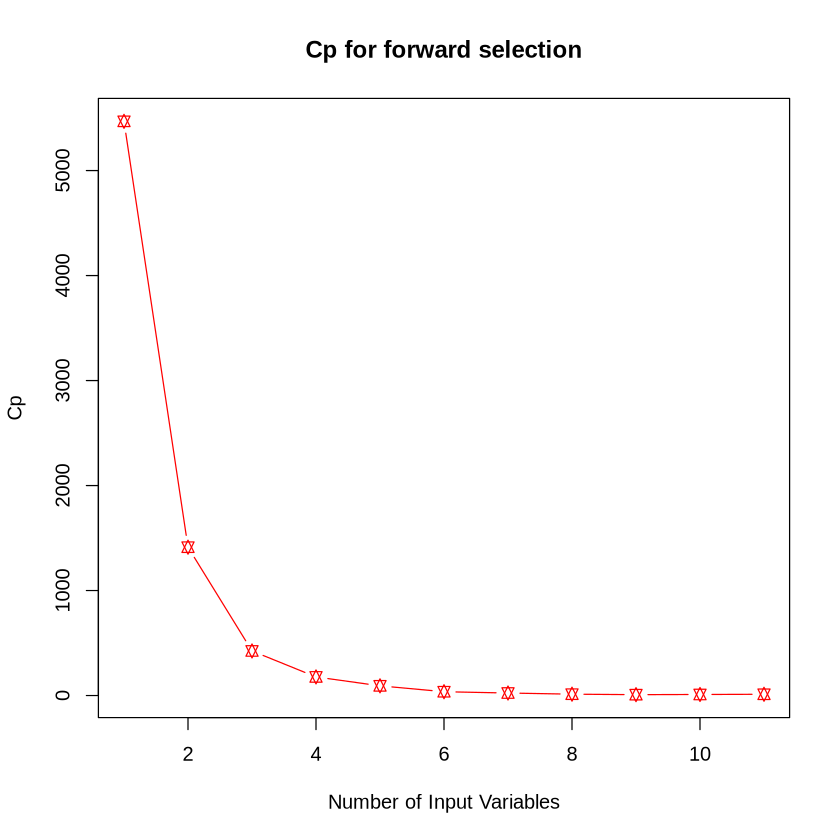

In [11]:
plot(summary(repo_forward_sel)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", 
     ylab = "Cp",
     type = "b",
     pch = 11,
     col = "red"
)

In [12]:
# I use min cp value here to select variables for no reasons (we used in worksheet)... please change to other metrics if more reasonable!!!
cp_min = which.min(repo_forward_summary$cp) 

selected_var <- names(coef(repo_forward_sel, cp_min))[-1]
selected_var

[1] "Forks"               "Issues"              "Has.ProjectsTrue"   
[4] "Has.DownloadsTrue"   "Has.WikiTrue"        "Has.PagesTrue"      
[7] "Has.DiscussionsTrue" "Is.ArchivedTrue"     "Is.TemplateTrue"

In [13]:
selected_var <- gsub("True", "", selected_var)
selected_var

[1] "Forks"           "Issues"          "Has.Projects"    "Has.Downloads"  
[5] "Has.Wiki"        "Has.Pages"       "Has.Discussions" "Is.Archived"    
[9] "Is.Template"

In [14]:
# subset only the predictors selected from the full dataset
training_subset <- 
    training_repo %>% 
    select(all_of(selected_var), Stars)

testing_subset <- 
    testing_repo %>% 
    select(all_of(selected_var), Stars)

head(training_subset)

,Forks,Issues,Has.Projects,Has.Downloads,Has.Wiki,Has.Pages,Has.Discussions,Is.Archived,Is.Template,Stars
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1,32,36,True,True,False,False,False,False,False,237
2,125,62,True,True,True,False,True,False,False,237
3,28,9,True,True,True,False,True,False,False,237
4,36,23,False,True,True,True,False,False,False,237
5,74,57,True,True,True,False,True,False,False,237
6,72,17,True,False,True,False,False,False,False,237


## Discussion

## References